In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

c:\ProgramData\anaconda3\envs\DL\Lib\site-packages\torch\cuda\__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


In [2]:
# myCNN 클래스 정의
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(128*3*3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 128*3*3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [3]:
# 데이터를 불러옵니다.
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root= './data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [5]:
# FashionMNIST의 정규화를 위해 train data의 평균과 표준편차를 구합니다.

def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        images_count_in_batch = images.size(0)
        images = images.view(images_count_in_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += images_count_in_batch

    mean /= total_images_count
    std /= total_images_count
    return mean, std
mean, std = calculate_mean_std(train_loader)

In [6]:
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.2860])
Std: tensor([0.3205])


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3205,)) #평균/표준편차로 정규화
])

train_dataset = datasets.FashionMNIST(root= './data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root= './data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)
# MNIST 데이터셋을 다운받아 DataLoader로 저장

In [8]:
# 모델, 손실 함수, 최적화 알고리즘 설정
model = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [9]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train(model, train_loader, optimizer):
    model.train() # 모델(아까 만든 myCNN)을 훈련모드로 구동
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        optimizer.zero_grad() # 최적의 함수의 기울기 초기화
        output = model(data) # 모델을 통한 데이터 예측 수행
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward() # 역전파 실행해 기울기 계산()
        optimizer.step() # 계산된 기울기를 통해 모델 가중치 업데이트 
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # 각 배치별로 loss변화를 확인
    #평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(100. * correct/ len(train_loader.dataset))
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')

In [10]:
def test(model, test_loader):
    model.eval() # 모델(아까 만든 myCNN)을 평가 모드로 구동
    test_loss = 0
    correct = 0
    with torch.no_grad(): # 기울기 계산 비활성화 
        for data, target in test_loader: # 배치를 반복하여 가장 높은 확률의 라벨을 예측값으로 설정
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [11]:
import time
start_time = time.time()

for epoch in range(0,10):
    start_epoch = time.time()
    train(model, train_loader, optimizer)
    test(model, test_loader)
    elapsed_time = time.time() - start_epoch
    print(f"Epoch time: {elapsed_time:.2f} seconds")
elapsed_time = time.time() - start_time
print(f"Total elapsed time: {elapsed_time:.2f} seconds")

Epoch 1, Train Loss: 0.8020
Test Loss: 0.5524, Accuracy: 79.62%
Epoch time: 76.66 seconds
Epoch 2, Train Loss: 0.4453
Test Loss: 0.4600, Accuracy: 82.25%
Epoch time: 76.43 seconds
Epoch 3, Train Loss: 0.3668
Test Loss: 0.3706, Accuracy: 86.78%
Epoch time: 75.15 seconds
Epoch 4, Train Loss: 0.3238
Test Loss: 0.3563, Accuracy: 86.96%
Epoch time: 75.32 seconds
Epoch 5, Train Loss: 0.2976
Test Loss: 0.3338, Accuracy: 87.95%
Epoch time: 77.00 seconds
Epoch 6, Train Loss: 0.2751
Test Loss: 0.3024, Accuracy: 89.18%
Epoch time: 77.07 seconds
Epoch 7, Train Loss: 0.2576
Test Loss: 0.2976, Accuracy: 89.02%
Epoch time: 78.04 seconds
Epoch 8, Train Loss: 0.2432
Test Loss: 0.3083, Accuracy: 88.71%
Epoch time: 77.37 seconds
Epoch 9, Train Loss: 0.2307
Test Loss: 0.3023, Accuracy: 89.16%
Epoch time: 75.28 seconds
Epoch 10, Train Loss: 0.2187
Test Loss: 0.2644, Accuracy: 90.59%
Epoch time: 76.22 seconds
Total elapsed time: 764.54 seconds


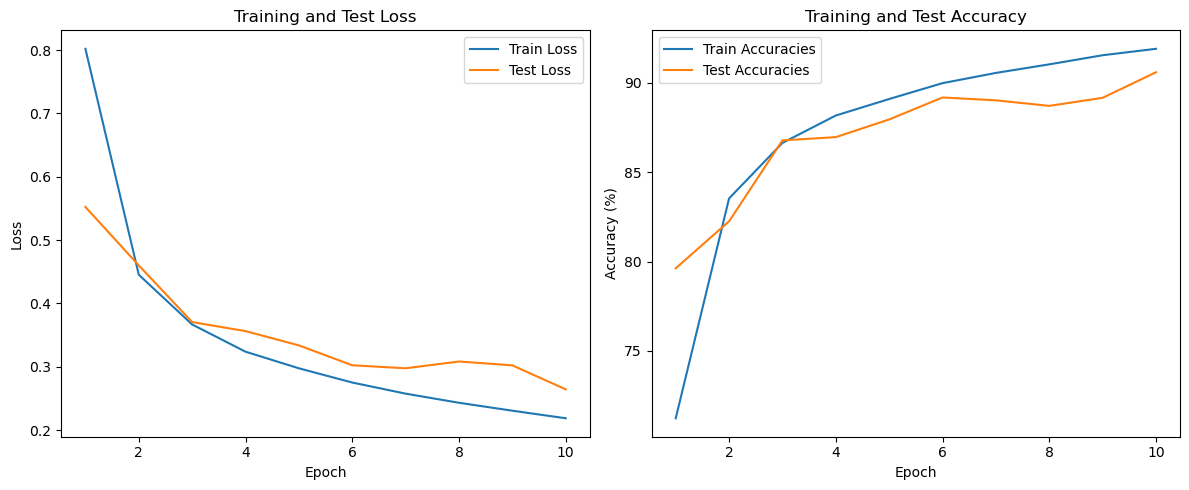

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
axes[0].plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Training and Test Loss')

# 정확도 그래프 
axes[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracies')
axes[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracies')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()